Changing the weight in eq.(1) of https://arxiv.org/pdf/1710.04626.pdf

In [81]:
import numpy as np
from sklearn import datasets, mixture
from src.embedding import BaseEmb, new_HeatGeo
from src.filter_approx import Heat_filter
from src.dataset import SwissRoll
import matplotlib.pyplot as plt
from typing import Union
from src.utils import interpolate, time_entropy, get_optimal_heat
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import seaborn as sns

with heat kernel weights, and scale factor =2, our losse is closer to sne. 

In [55]:
import numpy as np
from sklearn.neighbors import kneighbors_graph as KNN   # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
from sklearn.neighbors import NearestNeighbors as KNN2  # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html  and  https://stackoverflow.com/questions/21052509/sklearn-knn-usage-with-a-user-defined-metric
import os
import pickle
import matplotlib.pyplot as plt
import glob
from sklearn.metrics.pairwise import pairwise_kernels


class My_SNE:

    def __init__(self, y=None, n_components=2, learning_rate=0.1, max_iterations=1000, step_checkpoint=20):
        # X: rows are features and columns are samples
        # labels y is only for plotting the embeddings --> if set None, it does not plot
        self.n_components = n_components
        self.y = y
        self.max_iterations = max_iterations
        self.step_checkpoint = step_checkpoint
        self.learning_rate = learning_rate

    def fit_transform(self, X, continue_from_which_iteration=None):
        X = X.T
        n_training_images = X.shape[1]
        data_dimension = X.shape[0]
        path_to_save = './saved_files/SNE/'

        X_transformed = np.random.rand(self.n_components, n_training_images)  # --> rand in [0,1)
        # save the information at checkpoints:
        print("Calculating p for all pairs...")
        distance_matrix_originalSpace = self.get_distances_btw_points(data_matrix=X)
        p_matrix = np.zeros((n_training_images, n_training_images))
        for sample_index1 in range(n_training_images):
            print("---processing for image " + str(sample_index1))
            sigma = 1 / (2 ** 0.5)
            d_squared_of_row = (distance_matrix_originalSpace[sample_index1, :] ** 2) / (2 * (sigma ** 2))
            d_squared_of_row_diagonalElementRemoved = np.delete(d_squared_of_row, sample_index1)   # remove the sample_index1-th column of minus_d_of_row
            minus_d_squared_of_row_diagonalElementRemoved = -1 * d_squared_of_row_diagonalElementRemoved
            minus_d_squared_of_row = -1 * d_squared_of_row
            denominator = np.sum(np.exp(minus_d_squared_of_row_diagonalElementRemoved))
            for sample_index2 in range(n_training_images):
                if sample_index1 != sample_index2:
                    numerator = np.exp(minus_d_squared_of_row[sample_index2])  # the sample_index2-th column of minus_d_of_row
                    p = numerator / denominator
                else:
                    p = 0
                p_matrix[sample_index1, sample_index2] = p
        if continue_from_which_iteration is not None:
            iteration_index = continue_from_which_iteration
        else:
            iteration_index = -1
        cost_iters = np.zeros((self.step_checkpoint, 1))
        update = 0
        while True:
            iteration_index = iteration_index + 1
            #----- update alpha:
            if iteration_index < 250:
                alpha = 0.5   
            else:
                alpha = 0.8  
            print("Iteration " + str(iteration_index) + "...")
            distance_matrix_embeddedSpace = self.get_distances_btw_points(data_matrix=X_transformed)
            q_matrix = np.zeros((n_training_images, n_training_images))
            for sample_index1 in range(n_training_images):
                d_squared_of_row = (distance_matrix_embeddedSpace[sample_index1, :] ** 2)
                d_squared_of_row_diagonalElementRemoved = np.delete(d_squared_of_row, sample_index1)   # remove the sample_index1-th column of minus_d_of_row
                minus_d_squared_of_row_diagonalElementRemoved = -1 * d_squared_of_row_diagonalElementRemoved
                minus_d_squared_of_row = -1 * d_squared_of_row
                denominator = np.sum(np.exp(minus_d_squared_of_row_diagonalElementRemoved))
                for sample_index2 in range(n_training_images):
                    if sample_index1 != sample_index2:
                        numerator = np.exp(minus_d_squared_of_row[sample_index2])  # the sample_index2-th column of minus_d_of_row
                        q = numerator / denominator
                    else:
                        q = 0
                    q_matrix[sample_index1, sample_index2] = q
            for sample_index1 in range(n_training_images):
                X_i_transformed_previousIteration = X_transformed[:, sample_index1].reshape((-1, 1))
                gradient = np.zeros((self.n_components, 1))
                for sample_index2 in range(n_training_images):
                    X_j_transformed_previousIteration = X_transformed[:, sample_index2].reshape((-1, 1))
                    p_ij = p_matrix[sample_index1, sample_index2]
                    p_ji = p_matrix[sample_index2, sample_index1]
                    q_ij = q_matrix[sample_index1, sample_index2]
                    q_ji = q_matrix[sample_index2, sample_index1]
                    gradient = gradient + (p_ij - q_ij + p_ji - q_ji) * (X_i_transformed_previousIteration - X_j_transformed_previousIteration)
                gradient = gradient * 2
                update = - (self.learning_rate * gradient) + (alpha * update)
                X_i_transformed = X_i_transformed_previousIteration + update
                X_transformed[:, sample_index1] = X_i_transformed.ravel()
            #--- add some jitter:
            if iteration_index < 50:
                for sample_index in range(n_training_images):
                    noise = np.random.normal(0, 0.1, self.n_components)
                    X_transformed[:, sample_index] = X_transformed[:, sample_index] + noise
            #--- calculate cost:
            cost = 0
            for sample_index1 in range(n_training_images):
                for sample_index2 in range(n_training_images):
                    if sample_index2 != sample_index1:
                        p_ij = p_matrix[sample_index1, sample_index2]
                        q_ij = q_matrix[sample_index1, sample_index2]
                        if p_ij != 0 and q_ij != 0:
                            cost = cost + (p_ij * np.log10(p_ij)) - (p_ij * np.log10(q_ij))
            print("---- cost of this iteration: " + str(cost))
            index_to_save = iteration_index % self.step_checkpoint
            cost_iters[index_to_save] = cost
            # --- check terminate:
            if self.max_iterations is not None:
                if iteration_index > self.max_iterations:
                    return X_transformed.T
                
    def get_distances_btw_points(self, data_matrix):
        # data_matrix: rows are features and columns are samples
        n_samples = data_matrix.shape[1]
        distance_matrix = KNN(X=data_matrix.T, n_neighbors=n_samples-1, mode='distance', include_self=False, n_jobs=-1)
        distance_matrix = distance_matrix.toarray()
        return distance_matrix

In [209]:
data, labels = datasets.make_blobs(n_samples=500,n_features=10, centers=4, random_state=42, cluster_std=1)
knn=5
tau="auto"
methods = {#"SNE": My_SNE(max_iterations=80),
           "Ref": TSNE(n_components=2),
           "HeatGeo": new_HeatGeo(knn=knn,tau=tau),
           "HeatGeo Weighted": new_HeatGeo(knn=knn,tau=tau, mds_weights_type="heat_kernel", scale_factor=2),}

In [210]:
embeddings = []
for name, method in methods.items():
    print(name)
    embeddings.append(method.fit_transform(data))

Ref


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


HeatGeo


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo Weighted


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [1.00000000e-05 1.08595715e-02 1.00000000e-05 ... 1.00000000e-05
 1.00000000e-05 1.00000000e-05]


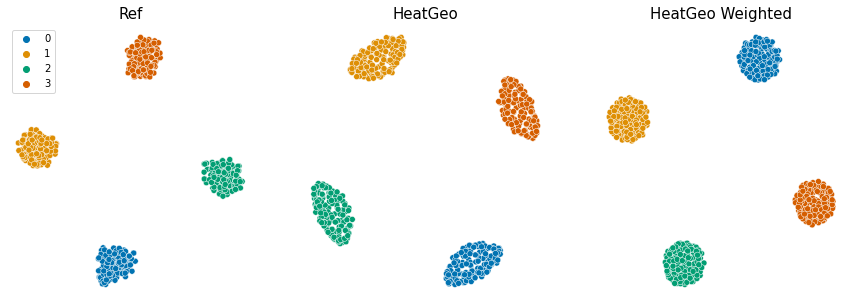

In [211]:
n = len(embeddings)
fig, axs = plt.subplots(1, n, figsize=(n*5, 5))
for i, (name, method) in enumerate(methods.items()):
    sns.scatterplot(x=embeddings[i][:,0], y=embeddings[i][:,1], hue=labels, ax=axs[i], palette="colorblind")
    
    if i == 0:
        axs[i].legend(loc='upper left')
    else:
        axs[i].get_legend().remove()
    axs[i].set_title(name, fontsize=15)
    axs[i].axis('off')

In [198]:
data, labels = datasets.make_blobs(n_samples=500,n_features=100, centers=4, random_state=52, cluster_std=1)
knn=5
tau="auto"
methods = {#"SNE": My_SNE(max_iterations=80),
           "Ref": TSNE(n_components=2),
           "HeatGeo": new_HeatGeo(knn=knn,tau=tau),
           "HeatGeo Weighted": new_HeatGeo(knn=knn,tau=tau, mds_weights_type="heat_kernel", scale_factor=2),}

In [199]:
embeddings = []
for name, method in methods.items():
    print(name)
    embeddings.append(method.fit_transform(data))

Ref


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


HeatGeo
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo Weighted
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [1.00000000e-05 1.00000000e-05 5.24586982e-03 ... 1.00000000e-05
 1.00000000e-05 1.00000000e-05]


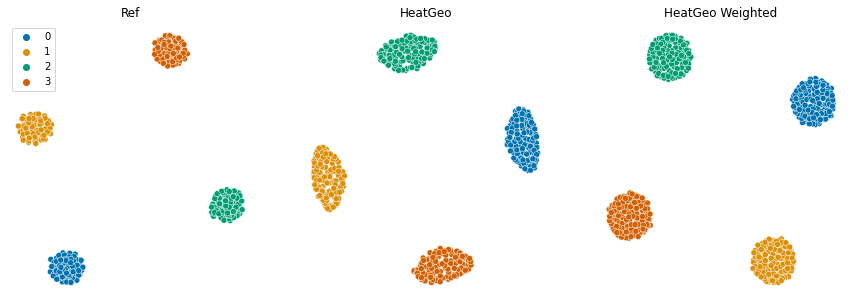

In [200]:
n = len(embeddings)
fig, axs = plt.subplots(1, n, figsize=(n*5, 5))
for i, (name, method) in enumerate(methods.items()):
    sns.scatterplot(x=embeddings[i][:,0], y=embeddings[i][:,1], hue=labels, ax=axs[i], palette="colorblind")
    if i == 0:
        axs[i].legend(loc='upper left')
    else:
        axs[i].get_legend().remove()
    axs[i].set_title(name)
    axs[i].axis('off')

In [141]:
data, labels = load_digits(return_X_y=True)
knn=10
tau="auto"
methods = {#"SNE": My_SNE(max_iterations=80),
            "Ref": TSNE(n_components=2, perplexity=50, early_exaggeration=20),
            "HeatGeo": new_HeatGeo(knn=knn,tau=tau),
           "HeatGeo Weighted": new_HeatGeo(knn=knn,tau=0.01, mds_weights_type="heat_kernel", scale_factor=2),}

In [142]:
embeddings = []
for name, method in methods.items():
    print(name)
    embeddings.append(method.fit_transform(data))

Ref


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


HeatGeo
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo Weighted
Using s_gd2 for MDS. [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.00000000e-05
 2.36676991e-04 1.00000125e-05]


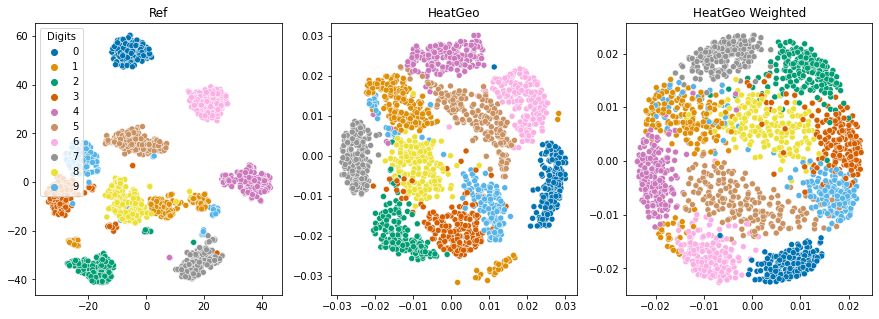

In [143]:
n = len(embeddings)
fig, axs = plt.subplots(1, n, figsize=(n*5, 5))
for i, (name, method) in enumerate(methods.items()):
    sns.scatterplot(x=embeddings[i][:,0], y=embeddings[i][:,1], hue=labels, ax=axs[i], palette="colorblind")
    axs[i].set_title(name)
    if i==0:
        axs[i].legend(loc='upper left', title="Digits")
    else:
        axs[i].legend().remove()

In [212]:
import scanpy as sc
pbmc = sc.datasets.pbmc3k_processed()
data = pbmc.X
labels = pbmc.obs["louvain"]
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)

In [213]:
knn=10
tau="auto"
methods = {#"SNE": My_SNE(max_iterations=80),
            "Ref": TSNE(n_components=2, perplexity=40, early_exaggeration=2),
             "HeatGeo": new_HeatGeo(knn=knn,tau=tau),
            "HeatGeo Weighted": new_HeatGeo(knn=knn,tau=1, mds_weights_type="heat_kernel", scale_factor=2),
        }

In [214]:
embeddings = []
for name, method in methods.items():
    print(name)
    embeddings.append(method.fit_transform(data))

Ref


/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


HeatGeo
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None
HeatGeo Weighted
Using s_gd2 for MDS. [1.00181738e-05 5.80813655e-05 1.00003090e-05 ... 5.62188181e-05
 1.03259362e-05 1.00841958e-05]


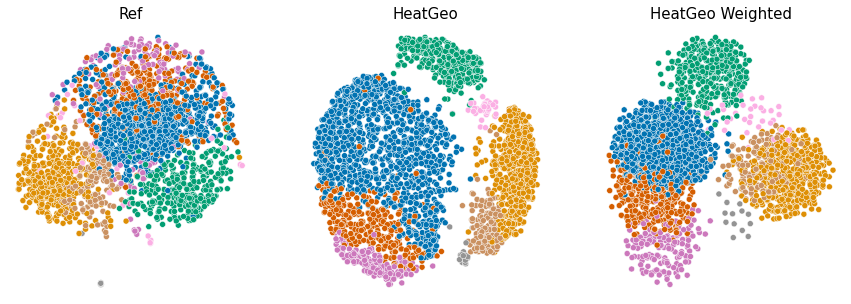

In [215]:
n = len(embeddings)
fig, axs = plt.subplots(1, n, figsize=(n*5, 5))
for i, (name, method) in enumerate(methods.items()):
    sns.scatterplot(x=embeddings[i][:,0], y=embeddings[i][:,1], hue=labels, ax=axs[i], palette="colorblind")
    axs[i].set_title(name, fontsize=15)
    axs[i].axis('off')
    # if i==0:
    #     axs[i].legend(loc='upper left', title="Digits")
    # else:
    axs[i].legend().remove()

/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


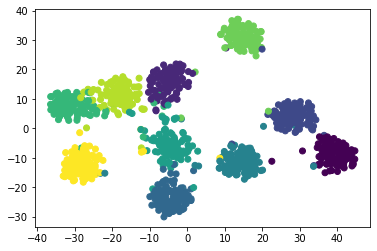

In [31]:
from sklearn.manifold import TSNE
emb = TSNE(n_components=2).fit_transform(data)
plt.scatter(emb[:,0],emb[:,1],c=labels)

Calculating PHATE...
  Running PHATE on 1000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.62 seconds.
Calculated PHATE in 1.53 seconds.


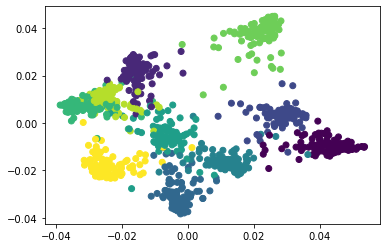

In [33]:
import phate
emb = phate.PHATE(n_components=2).fit_transform(data)
plt.scatter(emb[:,0],emb[:,1],c=labels)

Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.70865917 0.72066271 0.7083228  ... 0.73063222 0.71368255 0.71136287]


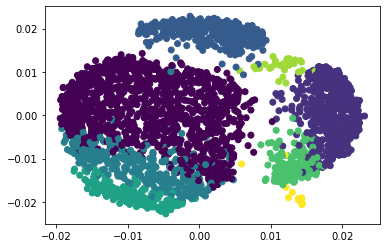

In [72]:
import scanpy as sc
pbmc = sc.datasets.pbmc3k_processed()
data = pbmc.X
labels = pbmc.obs["louvain"]
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)
mds_weights_type = "inv_dist"
mds_weights_args = 0.1
emb_op = new_HeatGeo(knn=5, tau="auto", mds_weights_type=mds_weights_type, mds_weights_args=mds_weights_args)
emb = emb_op.fit_transform(data)
plt.scatter(emb[:,0],emb[:,1],c=labels)

In [73]:
# create a list of embeddings for different parametrs of the mds weights
data, labels = datasets.make_blobs(n_samples=500,n_features=2, centers=4, random_state=42)
mds_weights_type = "inv_dist"
mds_weights_args_list = [0.01,0.05,0.1,0.5,1,5,10]
n = len(mds_weights_args_list)
embeddings = []
for i in range(n):
    emb_op = new_HeatGeo(knn=5, tau="auto", mds_weights_type=mds_weights_type, mds_weights_args=mds_weights_args_list[i])
    emb = emb_op.fit_transform(data)
    embeddings.append(emb)

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.96032834 0.96032834 0.96032834 ... 0.97114249 0.96032834 0.96032834]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.81676803 0.81676803 0.81676803 ... 0.86380312 0.81676803 0.81676803]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.66711001 0.66711001 0.66711001 ... 0.74615621 0.66711001 0.66711001]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.13212569 0.13212569 0.13212569 ... 0.23128318 0.13212569 0.13212569]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.0174572  0.0174572  0.0174572  ... 0.05349304 0.0174572  0.0174572 ]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [1.62133525e-09 1.62133525e-09 1.62133525e-09 ... 4.38014647e-07
 1.62133525e-09 1.62133525e-09]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [2.62872798e-18 2.62872798e-18 2.62872798e-18 ... 1.91852990e-13
 2.62872798e-18 2.62872798e-18]


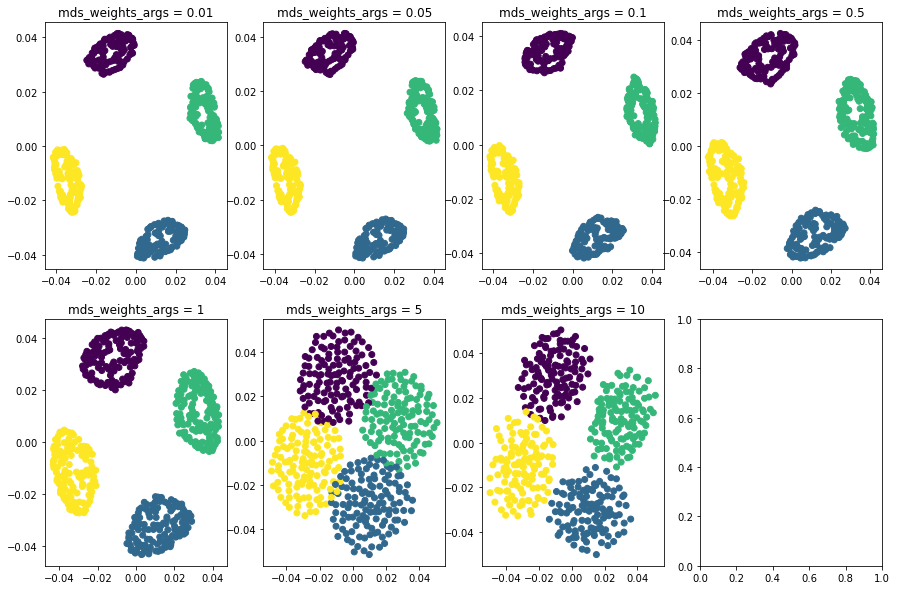

In [74]:
#plot these embeddings
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs = axs.ravel()
for i in range(n):
    axs[i].scatter(embeddings[i][:,0],embeddings[i][:,1],c=labels)
    axs[i].set_title("mds_weights_args = "+str(mds_weights_args_list[i]))
plt.show()

In [75]:
# Same thing using the gaussian type
data, labels = datasets.make_blobs(n_samples=500,n_features=2, centers=4, random_state=42)
mds_weights_type = "gaussian_dist"
mds_weights_args_list = [0.01,0.05,0.1,0.5,1,5,10]
n = len(mds_weights_args_list)
embeddings = []
for i in range(n):
    emb_op = new_HeatGeo(knn=5, tau="auto", mds_weights_type=mds_weights_type, mds_weights_args=mds_weights_args_list[i])
    emb = emb_op.fit_transform(data)
    embeddings.append(emb)

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [3.72007598e-44 3.72007598e-44 3.72007598e-44 ... 4.04092657e-01
 3.72007598e-44 3.72007598e-44]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [2.06115362e-09 2.06115362e-09 2.06115362e-09 ... 8.34266878e-01
 2.06115362e-09 2.06115362e-09]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [4.53999298e-05 4.53999298e-05 4.53999298e-05 ... 9.13379221e-01
 4.53999298e-05 4.53999298e-05]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.13533528 0.13533528 0.13533528 ... 0.98204154 0.13533528 0.13533528]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.36787944 0.36787944 0.36787944 ... 0.99097987 0.36787944 0.36787944]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.81873075 0.81873075 0.81873075 ... 0.99818939 0.81873075 0.81873075]


/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.90483742 0.90483742 0.90483742 ... 0.99909435 0.90483742 0.90483742]


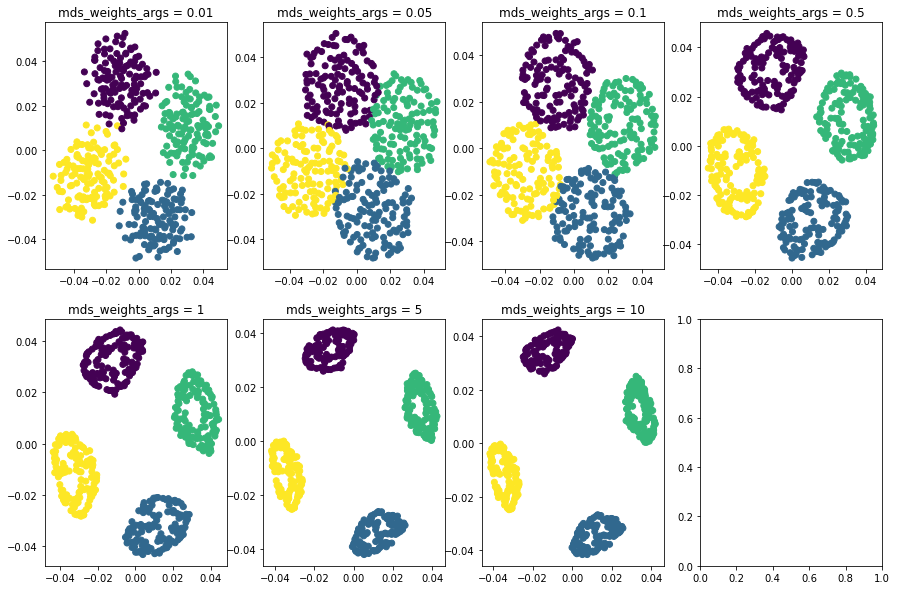

In [76]:
#plot these embeddings
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs = axs.ravel()
for i in range(n):
    axs[i].scatter(embeddings[i][:,0],embeddings[i][:,1],c=labels)
    axs[i].set_title("mds_weights_args = "+str(mds_weights_args_list[i]))
plt.show()

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 2
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.97774421e-02
 1.00000000e-05 1.00000000e-05]


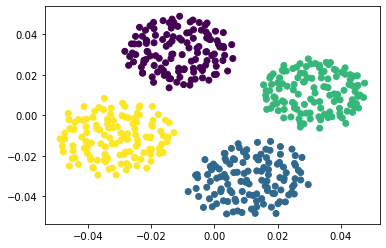

In [77]:
# using the heat weights
data, labels = datasets.make_blobs(n_samples=500,n_features=2, centers=4, random_state=42)
mds_weights_type = "heat_kernel"

emb_op = new_HeatGeo(knn=5, tau="auto", mds_weights_type=mds_weights_type)
emb = emb_op.fit_transform(data)
plt.scatter(emb[:,0],emb[:,1],c=labels)

In [78]:
# On pbmc with the inv_dist weights, for different values of the mds_weights_args
import scanpy as sc
pbmc = sc.datasets.pbmc3k_processed()
data = pbmc.X
labels = pbmc.obs["louvain"]
labels = labels.replace(to_replace=['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
value=[0,1,2,3,4,5,6,7]
)
mds_weights_type = "inv_dist"
mds_weights_args_list = [0.01,0.05,0.1,0.5,1,5,10]
n = len(mds_weights_args_list)
embeddings = []
for i in range(n):
    emb_op = new_HeatGeo(knn=5, tau="auto", mds_weights_type=mds_weights_type, mds_weights_args=mds_weights_args_list[i])
    emb = emb_op.fit_transform(data)
    embeddings.append(emb) 
    


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.96614816 0.96777234 0.96610229 ... 0.96910287 0.96683086 0.96651615]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.84181887 0.84891855 0.84161906 ... 0.85477027 0.8447973  0.84342325]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.70865942 0.72066273 0.70832306 ... 0.73063223 0.71368267 0.711363  ]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.17872552 0.19438387 0.17830175 ... 0.20820639 0.18515061 0.18216113]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [0.03194305 0.03778511 0.03179176 ... 0.04334992 0.03428087 0.03318281]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [3.32559184e-08 7.70198020e-08 3.24757698e-08 ... 1.53087878e-07
 4.73427039e-08 4.02308148e-08]
Optimal tau:  [22.26666667]
Using s_gd2 for MDS. [1.10604204e-15 5.93207970e-15 1.05476264e-15 ... 2.34360173e-14
 2.24141432e-15 1.61858536e-15]


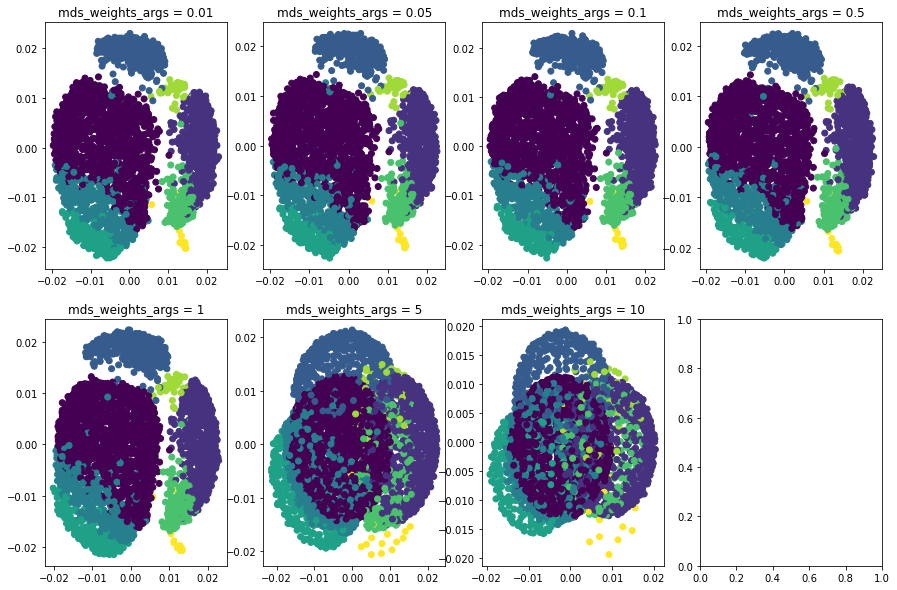

In [79]:
#plot these embeddings
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs = axs.ravel()
for i in range(n):  
    axs[i].scatter(embeddings[i][:,0],embeddings[i][:,1],c=labels)
    axs[i].set_title("mds_weights_args = "+str(mds_weights_args_list[i]))
plt.show()
